In [1]:
import numpy as np, pymc3 as pm, theano.tensor as T, matplotlib.pyplot as plt
import theano
floatX = theano.config.floatX

%matplotlib inline

/home/junpenglao/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
M    = 6  # number of columns in X - fixed effect
N    = 10 # number of columns in L - random effect
nobs = 10

# generate design matrix using patsy
from patsy import dmatrices
import pandas as pd
predictors = []
for s1 in range(N):
    for c1 in range(2):
        for c2 in range(3):
            for i in range(nobs):
                predictors.append(np.asarray([c1+1,c2+1,s1+1]))
tbltest             = pd.DataFrame(predictors, columns=['Condi1', 'Condi2', 'subj'])
tbltest['Condi1']   = tbltest['Condi1'].astype('category')
tbltest['Condi2']   = tbltest['Condi2'].astype('category')
tbltest['subj']     = tbltest['subj'].astype('category')
tbltest['tempresp'] = np.random.normal(size=(nobs*M*N,1))

Y, X    = dmatrices("tempresp ~ Condi1*Condi2", data=tbltest, return_type='matrix')
Terms   = X.design_info.column_names
_, L    = dmatrices('tempresp ~ -1+subj', data=tbltest, return_type='matrix')
X       = np.asarray(X) # fixed effect
L       = np.asarray(L) # mixed effect
Y       = np.asarray(Y) 
# generate data
w0 = [5.,1.5,2.,3.,1.1,1.25]
z0 = np.random.normal(size=(N,))
Pheno   = np.dot(X,w0) + np.dot(L,z0) + Y.flatten()

In [3]:
with pm.Model() as mixedEffect:
    ### hyperpriors
    h2     = pm.Uniform('h2')
    sigma2 = pm.HalfCauchy('sigma2', 5)
    #beta_0 = pm.Uniform('beta_0', lower=-1000, upper=1000)   # a replacement for improper prior
    w = pm.Normal('w', mu=0, sd=100, shape=M)
    z = pm.Normal('z', mu=0, sd=(h2*sigma2)**0.5, shape=N)
    g = T.dot(L, z)
    y = pm.Normal('y', mu=g + T.dot(X,w), 
                  sd=((1-h2)*sigma2)**0.5, observed=Pheno)

## ADVI

Average Loss = 951.01: 100%|██████████| 20000/20000 [00:13<00:00, 1453.93it/s] 
Finished [100%]: Average Loss = 950.98
Average Loss = 940.75: 100%|██████████| 10000/10000 [00:06<00:00, 1546.88it/s]
Finished [100%]: Average Loss = 940.74


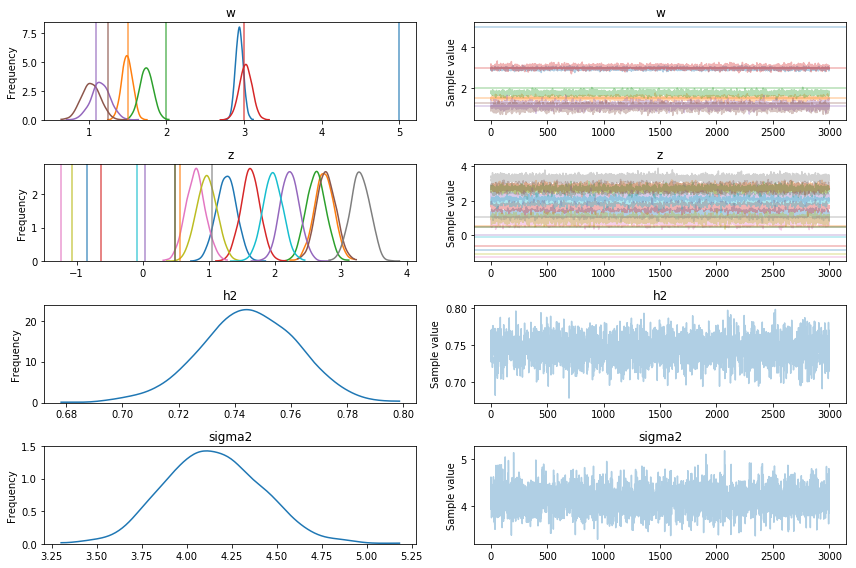

In [4]:
with mixedEffect:
    s = theano.shared(pm.floatX(1))
    inference = pm.ADVI(cost_part_grad_scale=s)
    # ADVI has nearly converged
    inference.fit(n=20000)
    # It is time to set `s` to zero
    s.set_value(0)
    approx = inference.fit(n=10000)
    trace_vi = approx.sample(3000) 
    
    elbos1 = -inference.hist

pm.traceplot(trace_vi, lines={'w':w0, 'z':z0});

No handles with labels found to put in legend.


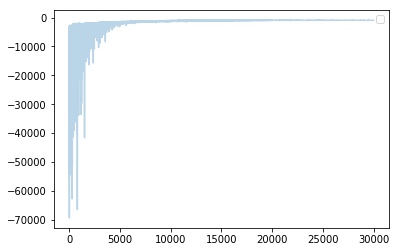

In [5]:
plt.figure()
plt.plot(elbos1, alpha=.3)
plt.legend()

## NUTS

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [z, w, sigma2, h2]
Sampling 2 chains: 100%|██████████| 8000/8000 [00:47<00:00, 168.07draws/s]


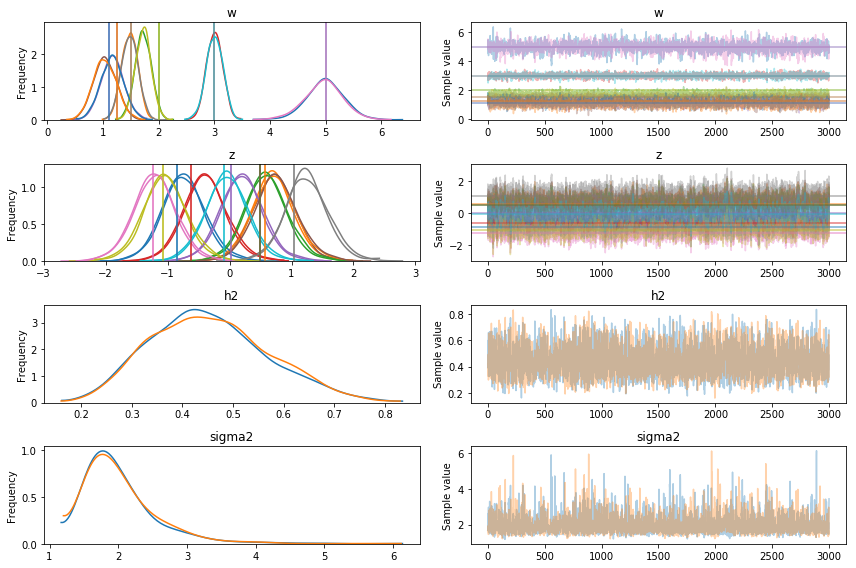

In [6]:
with mixedEffect:
    trace = pm.sample(3000, njobs=2, tune=1000)

pm.traceplot(trace, lines={'w':w0, 'z':z0});

### plot advi and NUTS (copy from pymc3 example)

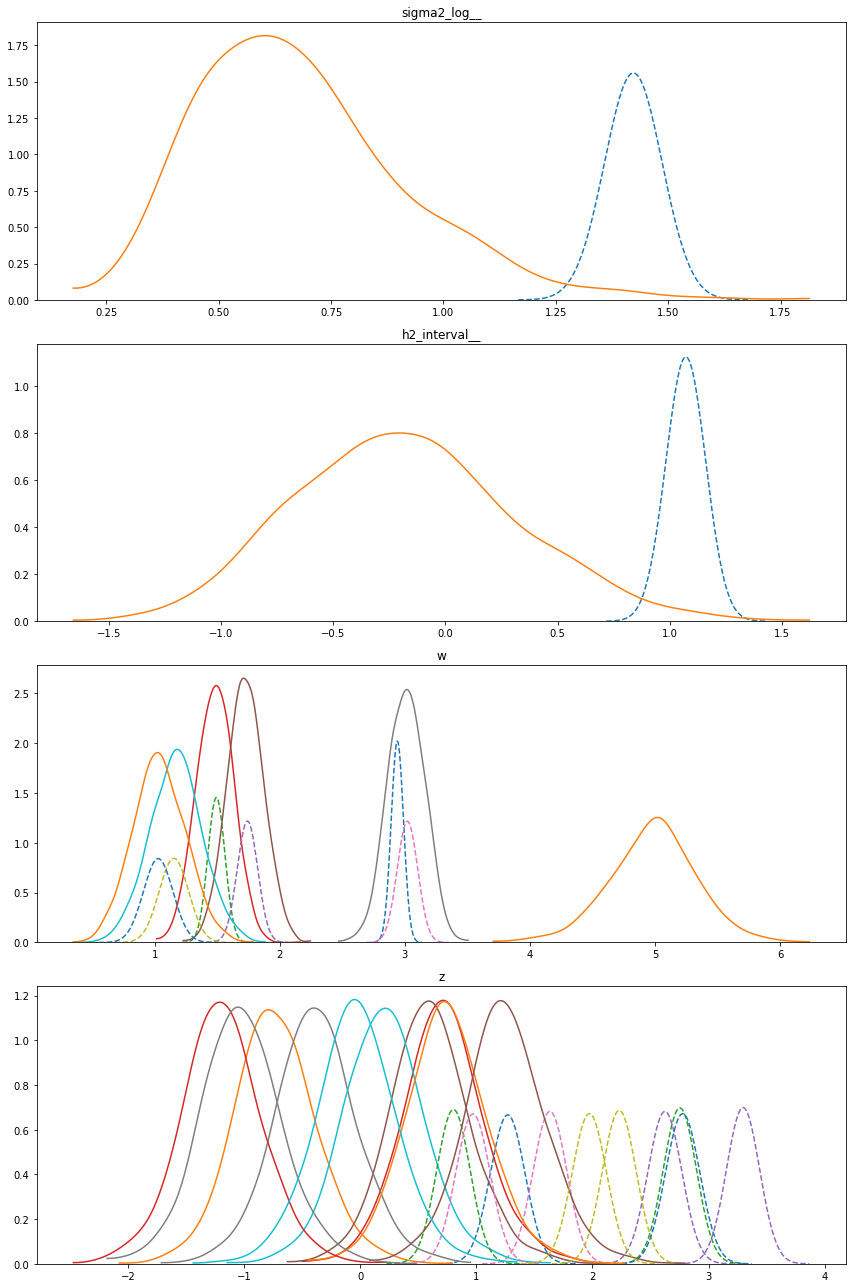

In [16]:
burnin = 1000
from scipy import stats
import seaborn as sns

gbij = approx.bij
means = gbij.rmap(approx.mean.eval())
cov = approx.cov.eval()
sds = gbij.rmap(np.diag(cov)**.5)

varnames = means.keys()
fig, axs = plt.subplots(nrows=len(varnames), figsize=(12, 18))
for var, ax in zip(varnames, axs):
    mu_arr = means[var]
    sigma_arr = sds[var]
    ax.set_title(var)
    for i, (mu, sigma) in enumerate(zip(mu_arr.flatten(), sigma_arr.flatten())):
        sd3 = (-4*sigma + mu, 4*sigma + mu)
        x = np.linspace(sd3[0], sd3[1], 300)
        y = stats.norm(mu, sigma).pdf(x)
        ax.plot(x, y/4., '--')
        if trace[var].ndim > 1:
            t = trace[burnin:][var][:, i]
        else:
            t = trace[burnin:][var]
        pm.kdeplot(t, ax=ax)
fig.tight_layout()

## DEMetropolis

/home/junpenglao/Documents/pymc3/pymc3/step_methods/metropolis.py:540: UserWarning: Population based sampling methods such as DEMetropolis are experimental. Use carefully and be extra critical about their results!
  warnings.warn('Population based sampling methods such as DEMetropolis are experimental.' \
Population sampling (50 chains)
DEMetropolis: [z, w, sigma2, h2]
Attempting to parallelize chains.
100%|██████████| 6000/6000 [05:10<00:00, 19.35it/s]
The number of effective samples is smaller than 10% for some parameters.


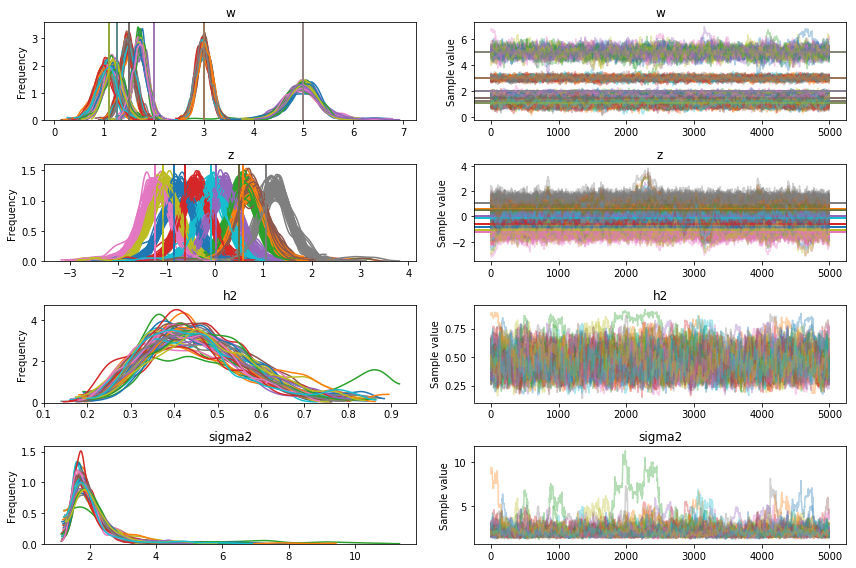

In [17]:
with mixedEffect:
    tracede = pm.sample(5000, njobs=50, tune=1000, step=pm.DEMetropolis(), parallelize=True)

pm.traceplot(tracede, lines={'w':w0, 'z':z0});

## SMC

Sample initial stage: ...
Beta: 0.000001 Stage: 0
100%|██████████| 10000/10000 [00:03<00:00, 3098.68it/s]
Beta: 0.000238 Stage: 1
100%|██████████| 10000/10000 [00:08<00:00, 1194.59it/s]
Beta: 0.002044 Stage: 2
100%|██████████| 10000/10000 [00:05<00:00, 1949.29it/s]
Beta: 0.004185 Stage: 3
100%|██████████| 10000/10000 [00:07<00:00, 1419.37it/s]
Beta: 0.006695 Stage: 4
100%|██████████| 10000/10000 [00:05<00:00, 1944.77it/s]
Beta: 0.010025 Stage: 5
100%|██████████| 10000/10000 [00:06<00:00, 1437.99it/s]
Beta: 0.014112 Stage: 6
100%|██████████| 10000/10000 [00:04<00:00, 2229.73it/s]
Beta: 0.019042 Stage: 7
100%|██████████| 10000/10000 [00:08<00:00, 1235.56it/s]
Beta: 0.024784 Stage: 8
100%|██████████| 10000/10000 [00:03<00:00, 2568.00it/s]
Beta: 0.030989 Stage: 9
100%|██████████| 10000/10000 [00:09<00:00, 1009.46it/s]
Beta: 0.037397 Stage: 10
100%|██████████| 10000/10000 [00:03<00:00, 2966.09it/s]
Beta: 0.044548 Stage: 11
100%|██████████| 10000/10000 [00:15<00:00, 660.34it/s]
Beta: 0.05226

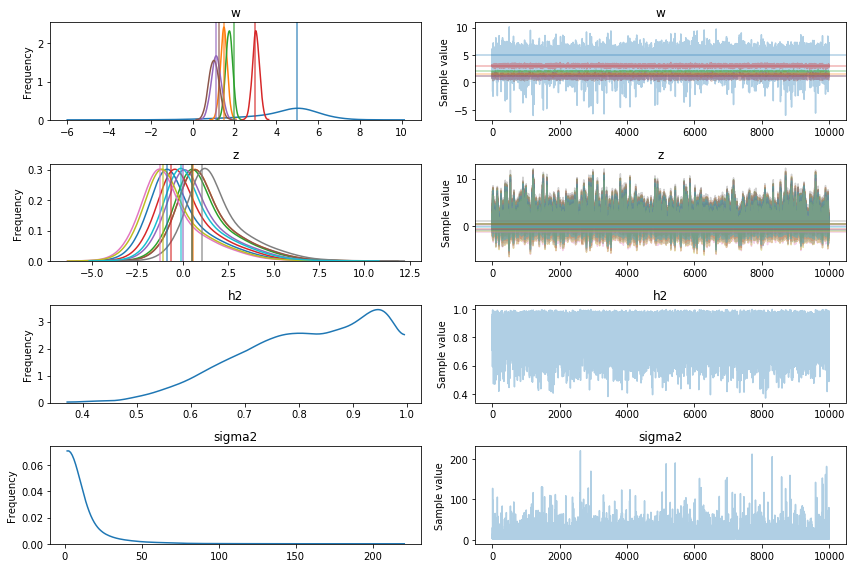

In [18]:
with mixedEffect:
    mtrace = pm.sample(10000, pm.SMC())

pm.traceplot(mtrace, lines={'w':w0, 'z':z0});

## Evaluate output

In [19]:
burnin=0
df_summary1 = pm.summary(trace[burnin:],varnames=['w'])
wpymc = np.asarray(df_summary1['mean'])
df_summary2 = pm.summary(trace[burnin:],varnames=['z'])
zpymc = np.asarray(df_summary2['mean'])

burnin=4000
df_summary1 = pm.summary(tracede[burnin:],varnames=['w'])
wpymcde = np.asarray(df_summary1['mean'])
df_summary2 = pm.summary(tracede[burnin:],varnames=['z'])
zpymcde = np.asarray(df_summary2['mean'])

df_summary1 = pm.summary(mtrace, varnames=['w'])
wpymc2 = np.asarray(df_summary1['mean'])
df_summary2 = pm.summary(mtrace, varnames=['z'])
zpymc2 = np.asarray(df_summary2['mean'])

w_vi1 = trace_vi['w'].mean(axis=0)
z_vi1 = trace_vi['z'].mean(axis=0)

In [25]:
import statsmodels.formula.api as smf
tbltest['Pheno'] = Pheno
md  = smf.mixedlm("Pheno ~ Condi1*Condi2", tbltest, groups=tbltest["subj"])
mdf = md.fit()
fe_params = pd.DataFrame(mdf.fe_params,columns=['LMM'])
random_effects = pd.DataFrame(mdf.random_effects)
random_effects = random_effects.transpose()
random_effects = random_effects.rename(index=str, columns={'Group': 'LMM'})

fe_params['NUTS'] = pd.Series(wpymc, index=fe_params.index)
random_effects['NUTS'] = pd.Series(zpymc, index=random_effects.index)

fe_params['DEM'] = pd.Series(wpymcde, index=fe_params.index)
random_effects['DEM'] = pd.Series(zpymcde, index=random_effects.index)

fe_params['SMC'] = pd.Series(wpymc2, index=fe_params.index)
random_effects['SMC'] = pd.Series(zpymc2, index=random_effects.index)

fe_params['MeanField'] = pd.Series(w_vi1, index=fe_params.index)
random_effects['MeanField'] = pd.Series(z_vi1, index=random_effects.index)

In [26]:
# ploting function 
def plotfitted(fe_params,random_effects,X,Z,Y):
    plt.figure(figsize=(18,9))
    ax1 = plt.subplot2grid((2,2), (0, 0))
    ax2 = plt.subplot2grid((2,2), (0, 1))
    ax3 = plt.subplot2grid((2,2), (1, 0), colspan=2)
    
    fe_params.plot(ax=ax1)
    random_effects.plot(ax=ax2)
    
    ax3.plot(Y.flatten(),'o',color='k',label = 'Observed', alpha=.25)
    for iname in fe_params.columns.get_values():
        fitted = np.dot(X,fe_params[iname])+np.dot(Z,random_effects[iname]).flatten()
        print("The MSE of "+iname+ " is " + str(np.mean(np.square(Y.flatten()-fitted))))
        ax3.plot(fitted,lw=1,label = iname, alpha=.5)
    ax3.legend(loc=0)
    #plt.ylim([0,5])
    plt.show()

The MSE of LMM is 1.0181461088982078
The MSE of NUTS is 1.0180786888926217
The MSE of DEM is 1.0181278807943486
The MSE of SMC is 1.0182671564091361
The MSE of MeanField is 1.0178593524744708


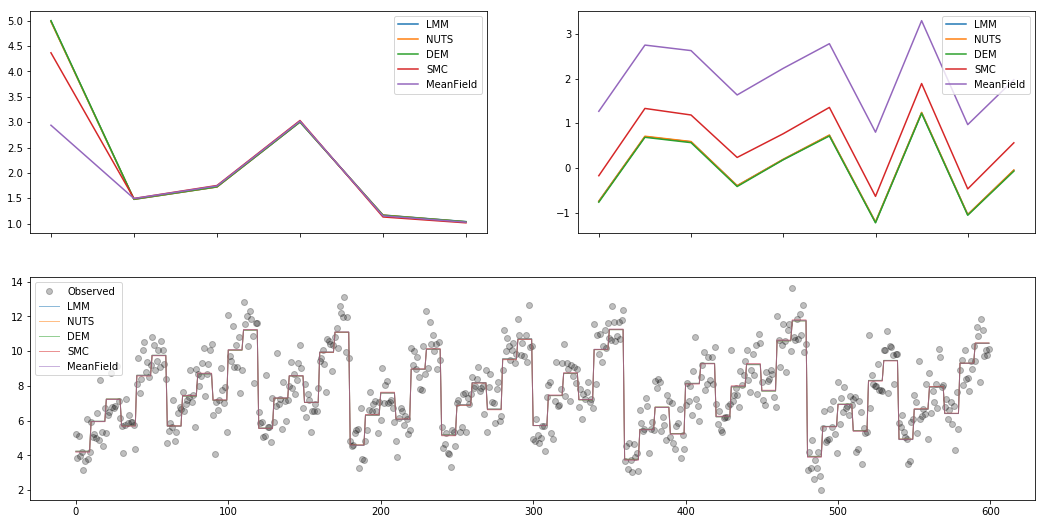

In [27]:
plotfitted(fe_params=fe_params,random_effects=random_effects,X=X,Z=L,Y=Pheno)